# Jar Targetting System
## Training Program
Liam Akkerman, Aidan Hunter

In [2]:
# import os
# os._exit(00)

In [3]:
# load libraries

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [32]:
# coords_to_image(y_data_raw, shape=(*x_data.shape[:3], 1))
def coords_to_image(coords, shape=(500,500,1), high_value=0.999):
    '''
    convert a list of tuples of jar coordinates into an image with dots at the centre location.
    TODO the high value must be lower than 1 for Keras.
    '''

    image = np.zeros(shape, dtype='float')
    for i, pt_list in enumerate(coords): # TODO rewrite with better looping
        for pt in pt_list:
            image[i, int(np.floor(pt[0])), int(np.floor(pt[1])), :] = high_value 
    return image

In [31]:
def image_to_coords(image, high_threashold=0.5):
    '''
    convert an image of jar centres into a list of tuples. the image contains a pixel at each coordinate of jar centres.
    '''

    if not image.ndim == 3:
        if image.ndim == 4 and image.shape[0] == 1:
            image = np.reshape(image, image.shape[1:])
        else:
            raise ValueError('misshapped image')
    
    coords = list()
    for x, column in enumerate(image):
        for y, value in enumerate(column): #TODO rewrite with better looping
            if value > high_threashold:
                coords.append((x,y))

    return coords

In [39]:
def overlay_centres(coords, ax):
    '''
    overlays list of coordinates as red circles onto a plt axis obeject (created with subplot)
    '''

    for point in coords:
        outline_marker = patches.Circle(point, radius=35, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(outline_marker)
        centre_marker = patches.Circle(point, radius=2, color='r')
        ax.add_patch(centre_marker)

In [4]:
# load the dataset

from glob import glob
import bz2
import pickle

dataset = list()

# loads every archive of the dataset
archive_list = glob('../dataset/*.pkl.bz2')
for archive in archive_list:
    with bz2.BZ2File(archive, mode='r') as f:
        dataset.extend(pickle.load(f))

In [26]:
# Split the data

x_data = np.asarray([a['image']/255.0 for a in dataset if not a['testing']], dtype='float')

y_data_raw = [a['label'] for a in dataset if not a['testing']]
y_data_coord = np.asarray(y_data_raw, dtype='object')
y_data_image = coords_to_image(y_data_raw, shape=(*x_data.shape[:3], 1))

print('loaded', len(x_data), 'datapoints')

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_image, test_size=0.2, shuffle=True)

print('training:', len(x_train), 'pts,\t testing:', len(x_test), 'pts')
print('X is shape', x_train.shape, '\tof type', type(x_train))
print('Y is shape', y_train.shape, '\tof type', type(y_train))


# clear the memeroy beacuse this is big
# dataset = None 
# x_data = None
# y_data = None

loaded 170 datapoints
training: 136 pts,	 testing: 34 pts
X is shape (136, 500, 500, 3) 	of type <class 'numpy.ndarray'>
Y is shape (136, 500, 500, 1) 	of type <class 'numpy.ndarray'>


<class 'tuple'>


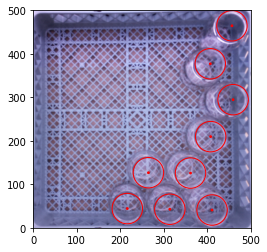

In [38]:
# visualize samples
from random import choice
import matplotlib.patches as patches

rand_image = choice(list(zip(x_data, y_data_coord)))
print(type(rand_image))
while len(rand_image[1]) < 5:    # make sure the chosen one is interesting
    rand_image = choice(list(zip(x_train, y_train)))

fig, ax = plt.subplots()
plt.imshow(rand_image[0])
plt.xlim([0, 500])
plt.ylim([0, 500])
#plt.axis('off')

overlay_centres(rand_image[1], ax)

In [7]:
# define the model layers
# TODO currently this is just the 4th CNN from assigment 3

model = keras.Sequential([
    keras.layers.Input(shape=x_data[0].shape),
    keras.layers.Conv2D(filters=1, kernel_size=3, activation='relu', padding='same'),
])

In [49]:
# train and evalute the model

model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=[keras.metrics.Recall()])

hist = model.fit(x=x_train, y=y_train, epochs=5)
loss, acc = model.evaluate(x=x_test, y=y_test)

print('test accuracy:', acc)
print('test loss:', loss)

Epoch 1/5
5/5 [==============================] - 5s 802ms/step - loss: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/5
5/5 [==============================] - 4s 782ms/step - loss: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/5
5/5 [==============================] - 4s 781ms/step - loss: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/5
5/5 [==============================] - 4s 781ms/step - loss: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/5
2/2 [==============================] - 1s 33ms/step - loss: 0.0000e+00 - recall: 0.0000e+00
test accuracy: 0.0
test loss: 0.0


(1, 500, 500, 3)
(1, 500, 500, 1)
found 0 centres
results: []


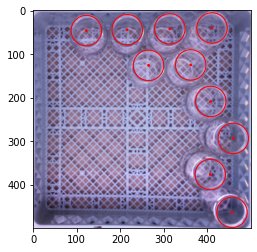

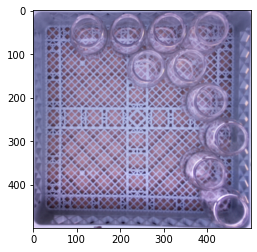

In [47]:
rand_image = choice(list(zip(x_test, y_test)))

rand_input = np.reshape(rand_image[0], (1, *rand_image[0].shape))
rand_output = np.reshape(rand_image[1], (1, *rand_image[1].shape))
print(rand_input.shape)
print(rand_output.shape)

fig, ax = plt.subplots()
plt.imshow(rand_image[0])
overlay_centres(image_to_coords(rand_image[1]), ax)


test_result = model.predict(rand_input)
print('found', np.count_nonzero(test_result), 'centres')
test_coords = image_to_coords(test_result)
print('results:', test_coords)
fig, ax = plt.subplots()
plt.imshow(rand_image[0])
overlay_centres(test_coords, ax)

In [10]:
# convert and save model

from datetime import datetime

# format is YYYYMMDDHHmm
filename = 'model-' + datetime.now().strftime('%Y%m%d%H%M') + '.tflite'
print('writing', filename)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(filename, 'wb') as f:
    f.write(tflite_model)

writing model-202104171245.tflite
INFO:tensorflow:Assets written to: C:\Users\liam\AppData\Local\Temp\tmpwuvumq06\assets
